#**Importing Libraries**

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

#**Loading Data**

In [27]:
#Data Loading
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df



#**Data Cleaning & EDA**

In [28]:
# Data Cleaning & EDA
def clean_and_eda(df):
    # Basic statistics
    print("Basic Statistics:\n", df.describe(include='all'))

    # Check for missing values
    print("\nMissing Values:\n", df.isnull().sum())

    # Display class distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x='target', data=df)
    plt.title('Class Distribution')
    plt.show()

    # Correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    # Pair plot for numerical features
    sns.pairplot(df, hue='target', diag_kind='kde')
    plt.suptitle('Pair Plot of Features', y=1.02)
    plt.show()

    # Distribution of numerical features
    num_cols = df.select_dtypes(include=np.number).columns
    df[num_cols].hist(figsize=(14, 10), bins=20)
    plt.suptitle('Distribution of Numerical Features')
    plt.show()

    # Box plots for numerical features
    plt.figure(figsize=(14, 10))
    for i, col in enumerate(num_cols):
        plt.subplot(4, 4, i+1)
        sns.boxplot(x='target', y=col, data=df)
        plt.title(f'Box Plot of {col}')
    plt.tight_layout()
    plt.show()

    # Correlation of features with the target
    corr_with_target = df.corr()['target'].sort_values(ascending=False)
    print("\nCorrelation of Features with Target:\n", corr_with_target)

    # Count plots for categorical features (if any)
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        plt.figure(figsize=(8, 6))
        sns.countplot(x=col, data=df, hue='target')
        plt.title(f'Count Plot of {col} by Target')
        plt.show()

    return df

#**Handle Missing Value**

In [29]:
# Handle Missing Values
def handle_missing_values(df):
    imputer = SimpleImputer(strategy='mean')  # Using 'mean' for numerical data
    df[df.columns] = imputer.fit_transform(df)
    return df



#**Feature Scaling**

In [30]:
# Feature Scaling
def scale_features(df):
    scaler = StandardScaler()
    num_cols = df.select_dtypes(include=np.number).columns
    df[num_cols] = scaler.fit_transform(df[num_cols])
    return df

#**Encode Labels**

In [31]:
# Encode Labels (if needed)
def encode_labels(df):
    if df['target'].dtype in ['int64', 'float64']:
        df['target'] = pd.cut(df['target'], bins=2, labels=[0, 1])  # Binarize the target
    return df

#**Handling Imbalance**

In [32]:
# Handling Imbalance
def handle_imbalance(X, y, method='smote'):
    if method == 'smote':
        sm = SMOTE(random_state=42)
        X_res, y_res = sm.fit_resample(X, y)
    elif method == 'undersample':
        rus = RandomUnderSampler(random_state=42)
        X_res, y_res = rus.fit_resample(X, y)
    elif method == 'combine':
        smote_enn = SMOTEENN(random_state=42)
        X_res, y_res = smote_enn.fit_resample(X, y)
    else:
        X_res, y_res = X, y

    return X_res, y_res

#**Model Training & Evaluation**

In [33]:
# Model Training and Evaluation
def train_and_evaluate_models(X, y):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(probability=True),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }

    results = {}
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for name, model in models.items():
        roc_auc = []
        precision = []
        recall = []
        f1 = []
        accuracy = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:,1]

            # Calculate metrics
            roc_auc.append(roc_auc_score(y_test, y_pred_proba))
            precision.append(precision_score(y_test, y_pred))
            recall.append(recall_score(y_test, y_pred))
            f1.append(f1_score(y_test, y_pred))
            accuracy.append(accuracy_score(y_test, y_pred))

        results[name] = {
            'ROC-AUC': np.mean(roc_auc),
            'Precision': np.mean(precision),
            'Recall': np.mean(recall),
            'F1 Score': np.mean(f1),
            'Accuracy': np.mean(accuracy)
        }

        print(f"{name}: ROC-AUC = {results[name]['ROC-AUC']:.4f}, Precision = {results[name]['Precision']:.4f}, Recall = {results[name]['Recall']:.4f}, F1 Score = {results[name]['F1 Score']:.4f}, Accuracy = {results[name]['Accuracy']:.4f}")

    return results

#**Baseline & SMOTE**

Basic Statistics:
               age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std     

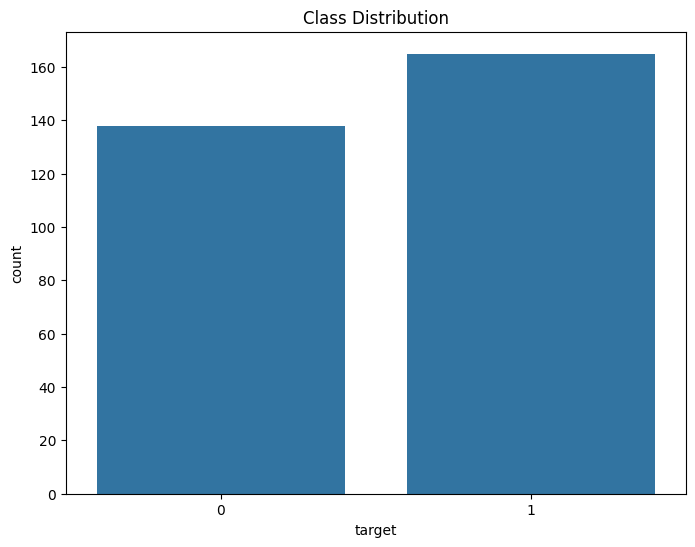

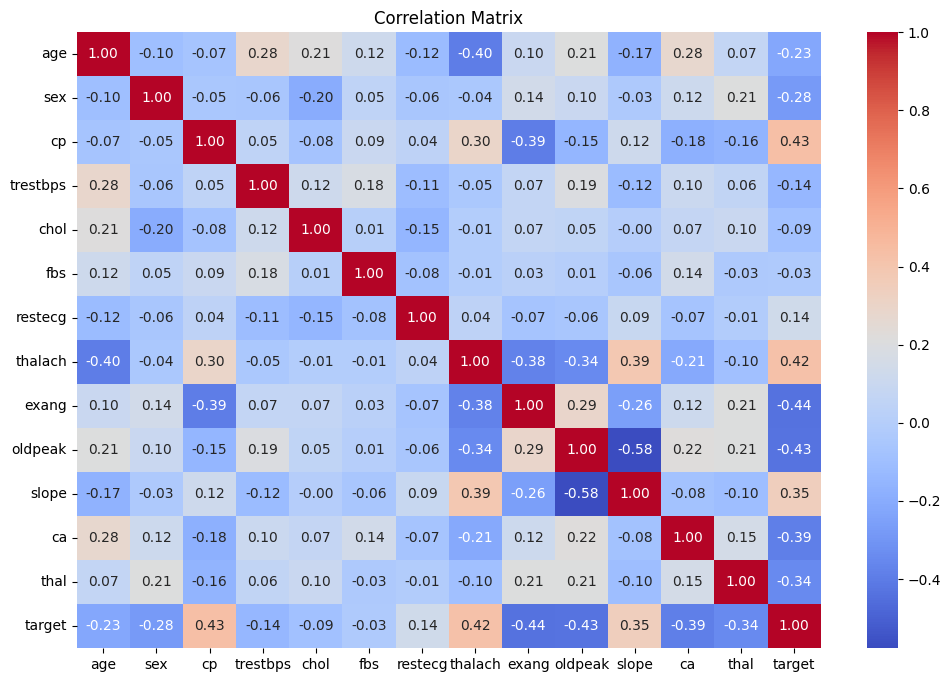

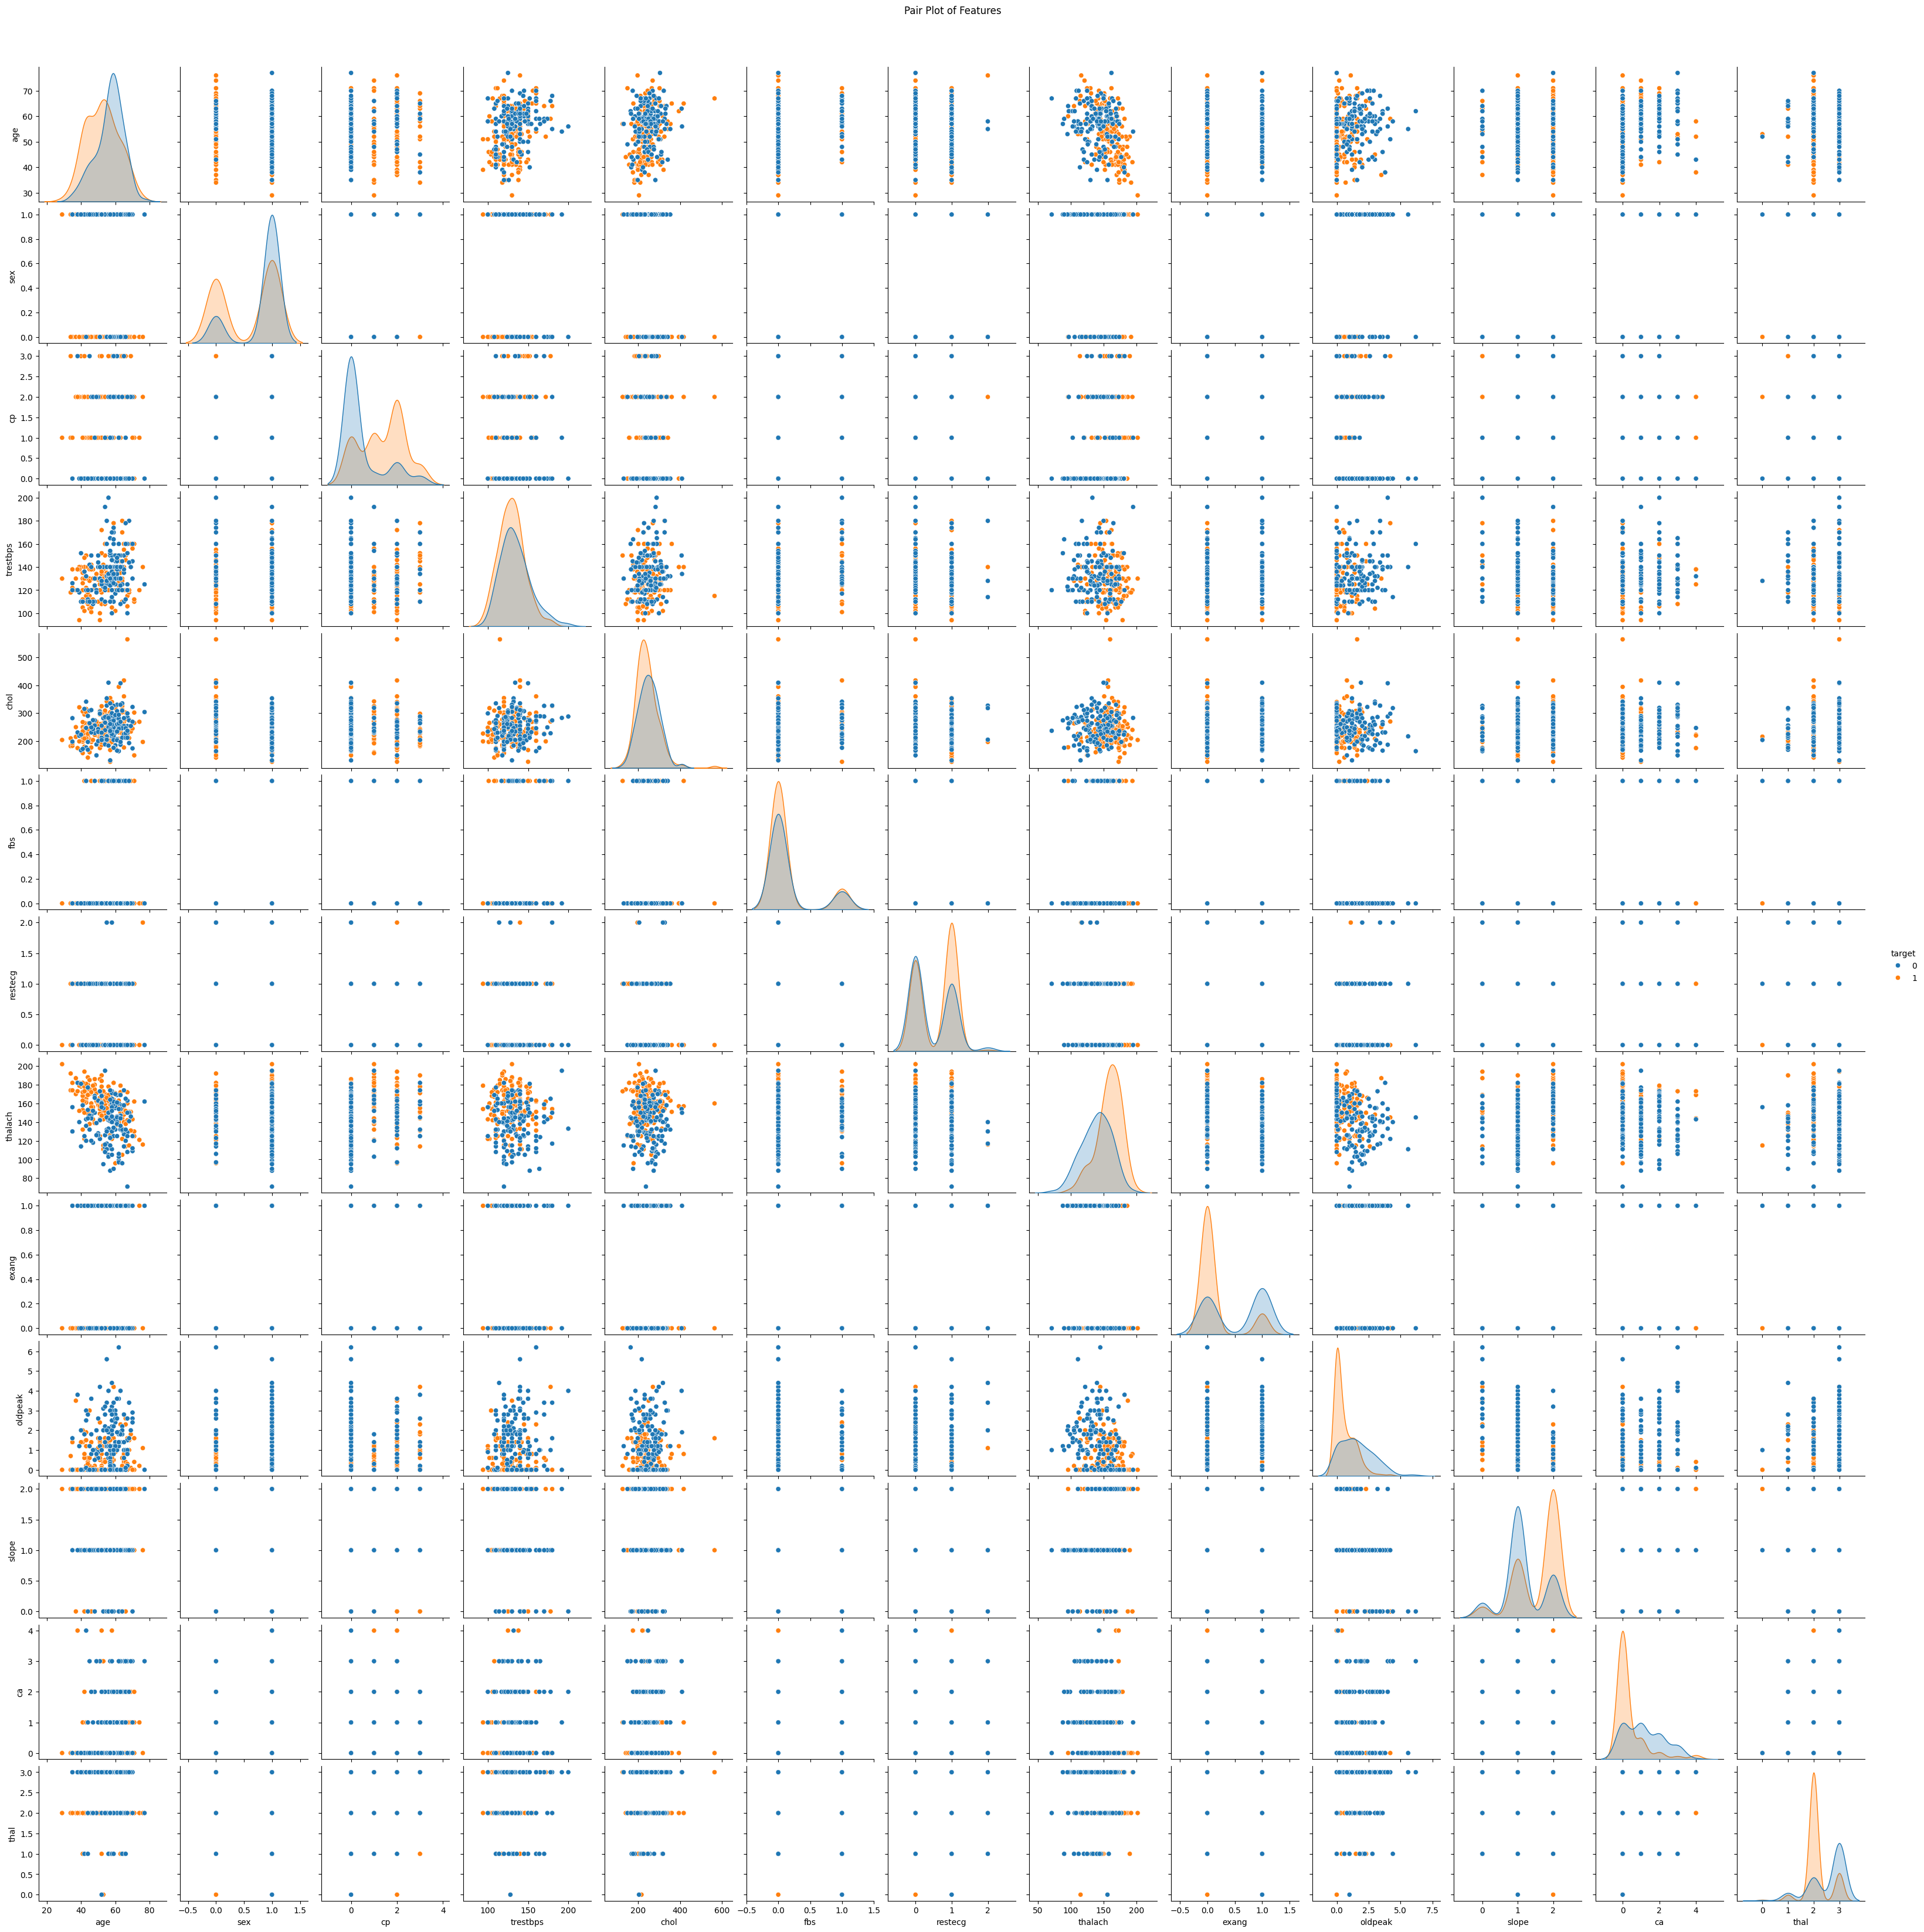

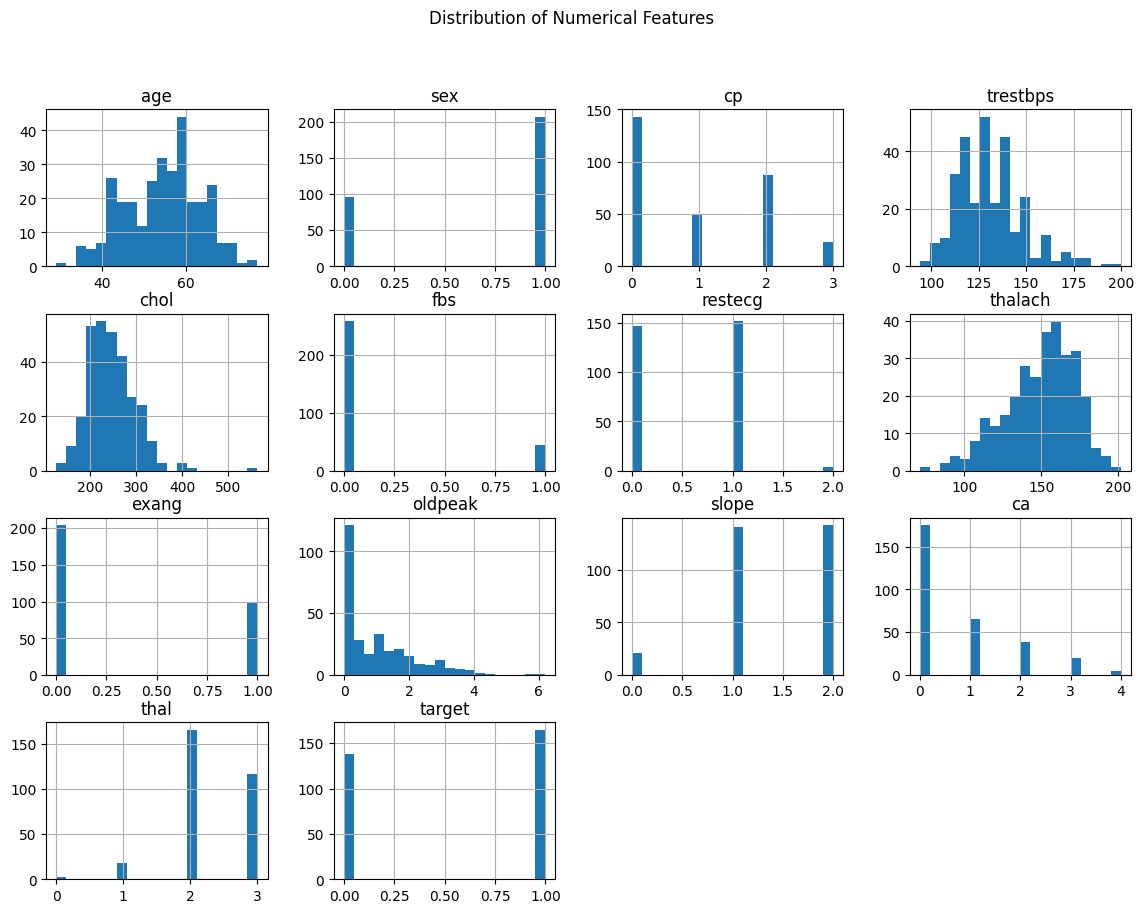

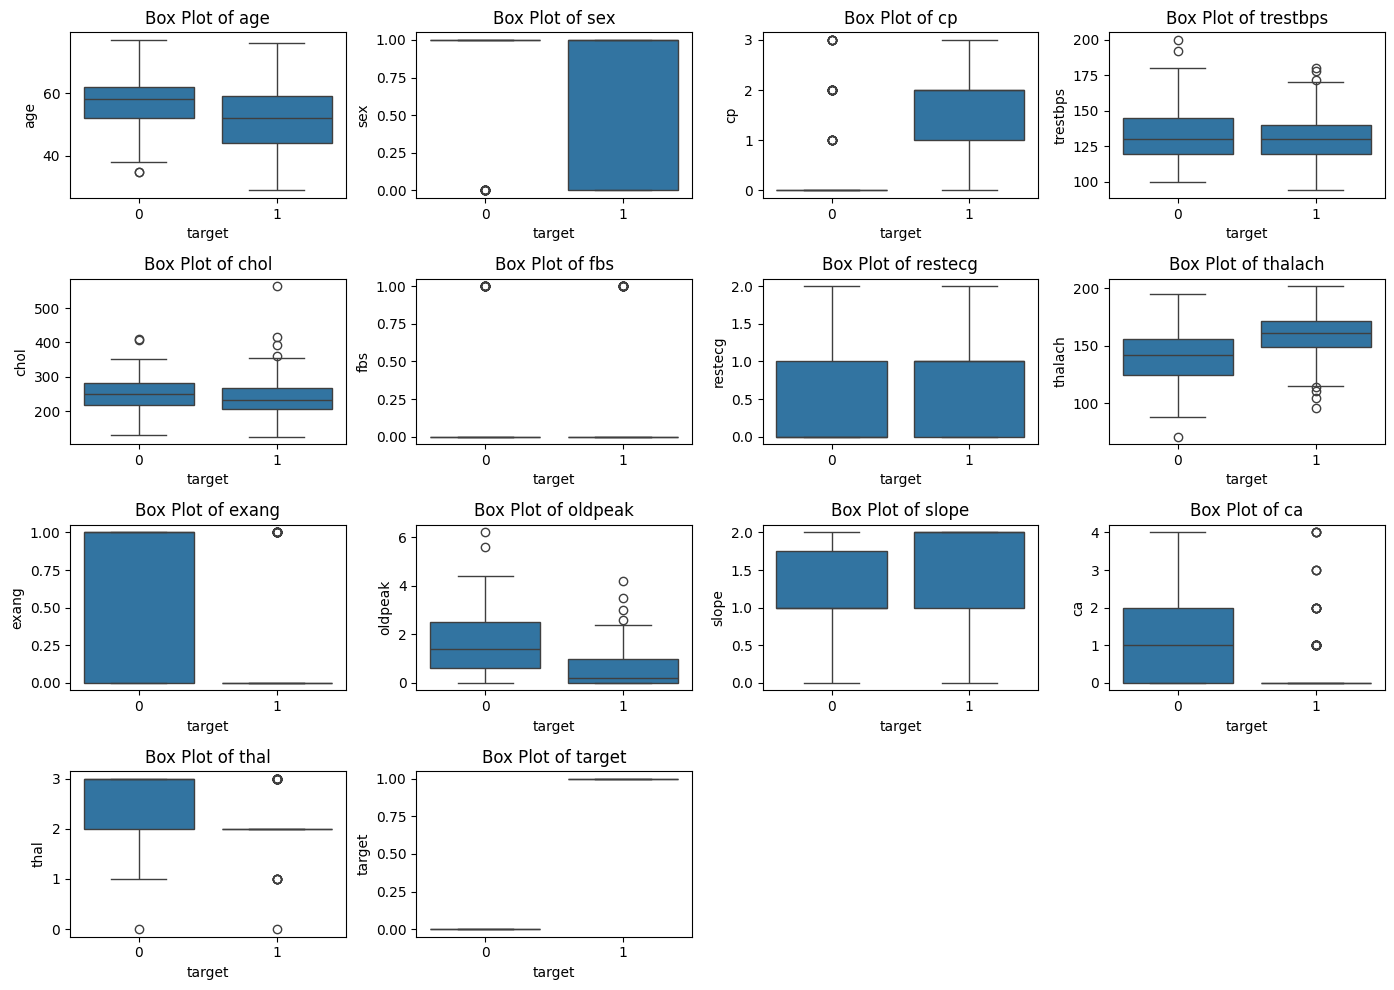


Correlation of Features with Target:
 target      1.000000
cp          0.433798
thalach     0.421741
slope       0.345877
restecg     0.137230
fbs        -0.028046
chol       -0.085239
trestbps   -0.144931
age        -0.225439
sex        -0.280937
thal       -0.344029
ca         -0.391724
oldpeak    -0.430696
exang      -0.436757
Name: target, dtype: float64

Training baseline models on imbalanced data...

Logistic Regression: ROC-AUC = 0.8996, Precision = 0.8120, Recall = 0.8847, F1 Score = 0.8452, Accuracy = 0.8216
Decision Tree: ROC-AUC = 0.7547, Precision = 0.7855, Recall = 0.7759, F1 Score = 0.7781, Accuracy = 0.7587
Random Forest: ROC-AUC = 0.9025, Precision = 0.8136, Recall = 0.8690, F1 Score = 0.8380, Accuracy = 0.8151
SVM: ROC-AUC = 0.8934, Precision = 0.8345, Recall = 0.8791, F1 Score = 0.8537, Accuracy = 0.8348


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:34:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:34:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:34:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:34:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:34:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost: ROC-AUC = 0.8738, Precision = 0.8106, Recall = 0.8351, F1 Score = 0.8207, Accuracy = 0.8018

Applying SMOTE and retraining models...

Logistic Regression: ROC-AUC = 0.9082, Precision = 0.8084, Recall = 0.8687, F1 Score = 0.8358, Accuracy = 0.8303
Decision Tree: ROC-AUC = 0.7929, Precision = 0.7854, Recall = 0.8103, F1 Score = 0.7955, Accuracy = 0.7939
Random Forest: ROC-AUC = 0.9190, Precision = 0.8536, Recall = 0.8422, F1 Score = 0.8463, Accuracy = 0.8485
SVM: ROC-AUC = 0.9134, Precision = 0.8347, Recall = 0.8655, F1 Score = 0.8463, Accuracy = 0.8424


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:34:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:34:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:34:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:34:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:34:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost: ROC-AUC = 0.8980, Precision = 0.8380, Recall = 0.8312, F1 Score = 0.8330, Accuracy = 0.8333

Baseline Results:
 {'Logistic Regression': {'ROC-AUC': 0.8996458650594444, 'Precision': 0.8119857561793046, 'Recall': 0.8847452667592736, 'F1 Score': 0.8451511821511822, 'Accuracy': 0.8215846994535518}, 'Decision Tree': {'ROC-AUC': 0.7547404648672903, 'Precision': 0.7855137844611528, 'Recall': 0.775929927457941, 'F1 Score': 0.7780997933144791, 'Accuracy': 0.7587431693989071}, 'Random Forest': {'ROC-AUC': 0.9024652126898541, 'Precision': 0.8135862432891295, 'Recall': 0.8689557930750631, 'F1 Score': 0.8379755047670281, 'Accuracy': 0.8151366120218579}, 'SVM': {'ROC-AUC': 0.8934190090741472, 'Precision': 0.8344701183853942, 'Recall': 0.879091102021917, 'F1 Score': 0.8536660527124722, 'Accuracy': 0.8348087431693989}, 'XGBoost': {'ROC-AUC': 0.8737607071299287, 'Precision': 0.8106401281718887, 'Recall': 0.8351150511910275, 'F1 Score': 0.8207449821772513, 'Accuracy': 0.8018032786885246}}

SMOT

In [34]:
def full_pipeline(file_path, balanced_file_path):
    df = load_data(file_path)
    df = clean_and_eda(df)
    df = handle_missing_values(df)
    df = encode_labels(df)
    df = scale_features(df)

    # Prepare X and y
    X = df.drop(['target'], axis=1).values
    y = df['target'].values

    # Train baseline models on imbalanced data
    print("\nTraining baseline models on imbalanced data...\n")
    baseline_results = train_and_evaluate_models(X, y)

    # Handle imbalance using SMOTE and retrain models
    print("\nApplying SMOTE and retraining models...\n")
    X_res, y_res = handle_imbalance(X, y, method='smote')
    smote_results = train_and_evaluate_models(X_res, y_res)

    # Save the balanced dataset
    balanced_df = pd.DataFrame(X_res, columns=df.drop(['target'], axis=1).columns)
    balanced_df['target'] = y_res
    balanced_df.to_csv(balanced_file_path, index=False)

    print("\nBaseline Results:\n", baseline_results)
    print("\nSMOTE Results:\n", smote_results)

    return baseline_results, smote_results

# Run the pipeline
file_path = 'heart.csv'
balanced_file_path = 'heart_balanced.csv'  # Path to save the balanced dataset
baseline_results, smote_results = full_pipeline(file_path, balanced_file_path)